# This file runs on Google Colab
## Running this file can take 20-25 minutes

In [1]:
# Import our dependencies
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,OneHotEncoder

In [2]:
# Importing data from RDS (AWS)
import psycopg2
connection = psycopg2.connect(
    host = 'sample-hotel-reviews.cfxm7dziqs2d.us-east-2.rds.amazonaws.com',
    port = 5432,
    user = 'postgres',
    password = 'Postgres$123',
    database = 'PySpark_NLP'
    )
cursor=connection.cursor()

# using pandas to execute SQL queries
import pandas as pd
sql = """
SELECT *
FROM public."db_for_nlp"
"""
df = pd.read_sql(sql, con=connection, index_col='review_id')

# Show DataFrame
df

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


,review,reviewer_sentiment
review_id,,
0,I am so angry that i made this post available...,negative
1,No real complaints the hotel was great great ...,positive
2,Rooms are nice but for elderly a bit difficul...,positive
3,My room was dirty and I was afraid to walk ba...,negative
4,You When I booked with your company on line y...,positive
...,...,...
512338,no trolly or staff to help you take the lugga...,positive
512339,The hotel looks like 3 but surely not 4 Brea...,positive
512340,The ac was useless It was a hot week in vienn...,negative


In [3]:
# Encoding 'reviewer_sentiment'
le = LabelEncoder()
df['reviewer_sentiment'] = le.fit_transform(df['reviewer_sentiment'])
df

,review,reviewer_sentiment
review_id,,
0,I am so angry that i made this post available...,0
1,No real complaints the hotel was great great ...,1
2,Rooms are nice but for elderly a bit difficul...,1
3,My room was dirty and I was afraid to walk ba...,0
4,You When I booked with your company on line y...,1
...,...,...
512338,no trolly or staff to help you take the lugga...,1
512339,The hotel looks like 3 but surely not 4 Brea...,1
512340,The ac was useless It was a hot week in vienn...,0


In [4]:
# Split our preprocessed data into our features/input and target/output arrays
y = df['reviewer_sentiment'].values
X = df.drop(['reviewer_sentiment'],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [5]:
# Compile, Train and Evaluate the Model
model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(model, output_shape=[8], input_shape=[], dtype=tf.string, trainable=True)
model = tf.keras.Sequential()

# First hidden layer
model.add(hub_layer)

# Output layer
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 400,041
Trainable params: 400,041
Non-trainable params: 0
_________________________________________________________________


In [6]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [7]:
# Fit/Train the model
fit_model = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
12009/12009 [==============================] - 111s 9ms/step - loss: 0.3572 - accuracy: 0.9569
Epoch 2/10
12009/12009 [==============================] - 111s 9ms/step - loss: 0.3563 - accuracy: 0.9569
Epoch 3/10
12009/12009 [==============================] - 112s 9ms/step - loss: 0.3563 - accuracy: 0.9569
Epoch 4/10
12009/12009 [==============================] - 115s 10ms/step - loss: 0.3563 - accuracy: 0.9569
Epoch 5/10
12009/12009 [==============================] - 115s 10ms/step - loss: 0.3563 - accuracy: 0.9569
Epoch 6/10
12009/12009 [==============================] - 110s 9ms/step - loss: 0.3562 - accuracy: 0.9569
Epoch 7/10
12009/12009 [==============================] - 110s 9ms/step - loss: 0.3560 - accuracy: 0.9569
Epoch 8/10
12009/12009 [==============================] - 109s 9ms/step - loss: 0.3551 - accuracy: 0.9569
Epoch 9/10
12009/12009 [==============================] - 110s 9ms/step - loss: 0.3537 - accuracy: 0.9569
Epoch 10/10
12009/12009 [===================

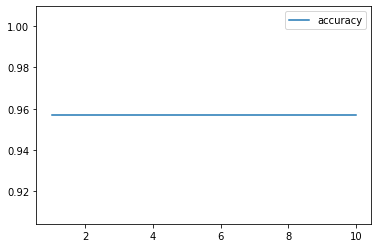

In [8]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the accuracy
history_df.plot(y="accuracy")

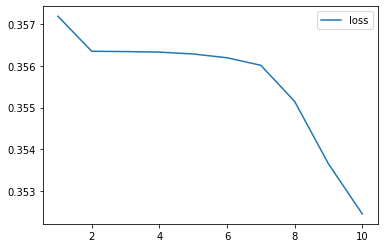

In [9]:
# Plot the loss
history_df.plot(y="loss")

In [10]:
# Test/Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

4003/4003 - 8s - loss: 0.3534 - accuracy: 0.9565
Loss: 0.35344988107681274, Accuracy: 0.9564589262008667


In [11]:
# Export our model to HDF5 file
model.save("NLP_Using_NN_1Layer.h5")